# Bad Sizes
Ants  
Bamboo  
Books (too big)

# Benchmark Run 

This notebook reviews the ```slurm-#######_#.out``` files that are generated when running ```continuousrun.sb```.  Specificall this file parses specific lines in the output file. These include the following examples. The first describes the setup of the run:

```Namespace(input_file='./see-segment/Image_data/Examples/Mushrooms.jpeg', input_mask='./see-segment/Image_data/Examples/Mushrooms_GT.png', seed=64467698, pop_size=10, num_iter=10)```

The others describe each generation's best so far.

```#BEST [0.9278057254150632,  ['XYZ', True, 2, 'Felzenszwalb', 0.9296875, 0.76953125, 0.46875, 0.53125, 0.1953125, 0.3125, 7, 17]]```


# Useful Command

Use the following command on a develompent node to cancel all currently running job arrays without canceling a jupyter ondemand instance:

```scancel `sq | grep _ | grep -v -e TIME | awk '{print $1}'` ```

Or use "SEE" name

```scancel -u $USER -n SEE```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pathlib import Path
import re

In [2]:
slurmoutdir = Path('.')
slurmfiles = slurmoutdir.glob('./WorkOUT/*.out')
slurmfiles = slurmoutdir.glob('./*.out')

filelist = []

for file in slurmfiles:
    jobnum = re.findall('-[0-9]*_', str(file))[0][1:-1]
    array = re.findall('_[0-9]*\.', str(file))[0][1:-1]
    item = [str(file), int(jobnum), int(array)]
    filelist.append(item)

df = pd.DataFrame(filelist, columns=['filename', 'jobid', 'arrayid'])
df = df.sort_values(by=['arrayid', 'jobid'])

In [3]:
def Namespace(input_file='', input_mask='', seed=60, pop_size=0, num_iter=0):
    ns = {}
    ns['input_file'] = input_file;
    ns['input_mask'] = input_mask;   
    ns['seed'] = seed;
    ns['pop_size'] = pop_size;
    ns['num_iter'] = num_iter
    #print(ns)
    return ns

In [4]:
def parseoutput(filename):
    bestsofar = []
    stats = {}
    times = []
    with open(filename, "r") as f:
        index = 0
        for line in f:
            if 'TRUE_BST' in line:
                vecstr = line[9:]
            if 'BEST' in line:
                vecstr = line[6:]
                x = eval(vecstr)
                x = [index] + x
                bestsofar.append(x)
            if 'Namespace' in line:
                data = line[10:-2].split(',')
                for item in data:
                    name,value = item.strip().split('=')
                    stats[name]=value   
            #if 'TIME' in line:
            #    times.append(float(line.split(' ')[1]))
            #if 'HASH' in line:
            #if slurmstepd: 
            index += 1

    return bestsofar, stats, times
    

In [5]:
examples = {}
iterations = {}
mystats = {}
times = {}
for index, row in df.iterrows():
    if True: #if f"_{item}." in row['filename']:
        bestsofar, stats, thistime = parseoutput(row['filename'])
        #print(f"{row['filename']} - {len(bestsofar)}")
        if not row['arrayid'] in examples:
            examples[row['arrayid']] = bestsofar
            iterations[row['arrayid']] = [ len(examples[row['arrayid']]) ]
            mystats[row['arrayid']] = stats
            times[row['arrayid']] = thistime
        else:
            examples[row['arrayid']] = examples[row['arrayid']] + bestsofar
            iterations[row['arrayid']].append(len(examples[row['arrayid']]))
            times[row['arrayid']] = times[row['arrayid']] + thistime
            if mystats[row['arrayid']] == None:
                mystats[row['arrayid']] = stats

rundata = {}
for arrayid in mystats:
    key = Path(mystats[arrayid]['input_file'][1:-1]).stem
    if not key in rundata:
        rundata[key] = mystats[arrayid]
        rundata[key]['iterations'] = [iterations[arrayid]]
        rundata[key]['data'] = [examples[arrayid]]
        if arrayid in times:
            if len(times[arrayid]) > 0:
                rundata[key]['times'] = [ (np.array(times[arrayid]) - times[arrayid][0])/1000/60 ]
    else:
        rundata[key]['data'].append(examples[arrayid])
        rundata[key]['iterations'].append(iterations[arrayid])
        if arrayid in times:
            if len(times[arrayid]) > 0:
                rundata[key]['times'].append((np.array(times[arrayid]) - times[arrayid][0])/1000/60)
                    

In [6]:
rundata.keys()

dict_keys(['AA_Chameleon', 'Airpods', 'ants', 'a_walk_in_the_park', 'Bambooplant', 'Books', 'bread', 'Cameron', 'Headphones', 'Leaves', 'Mushrooms', 'mz', 'SoapFilm', 'Street', 'Waterbottle'])

In [7]:
rundata['ants']['input_file']

"'./see-segment/Image_data/Examples/ants.jpg'"

In [8]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def plot_rundata(mydata, key='label', showimage=False):
    ax = plt.gca()
    legend = []
    maxx = 0
    for index,data in enumerate(mydata['data']):
        results = pd.DataFrame(data, columns=['index', 'fitness', 'individual'])
        trend = [1] + list(results['fitness']);
        plt.title(f"{key}")
        legend.append(f"{trend[-1]}")
        if len(mydata['iterations'][index]) > 1:
            for idx in mydata['iterations'][index]:
                plt.plot([idx, idx], [0, 1], 'r')
        maxx = max(maxx,len(trend))
        plt.plot(trend[:])
    if(showimage):
        arr_lena = mpimg.imread(mydata['input_file'][1:-1])
        imagebox = OffsetImage(arr_lena, zoom=0.1)
        ab = AnnotationBbox(imagebox, (maxx*0.8, 0.5))
        ax.add_artist(ab)
    plt.legend(legend)


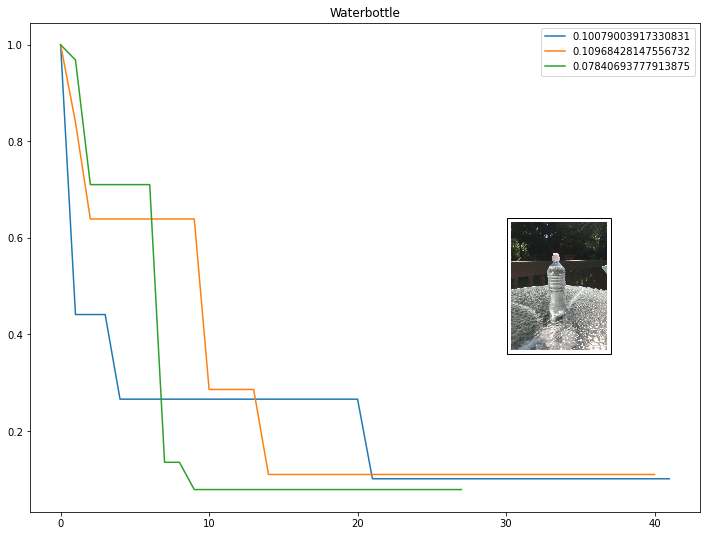

In [16]:
plt.figure(figsize=[12,9])
key = 'Waterbottle'
plot_rundata(rundata[key], key=key, showimage=True)

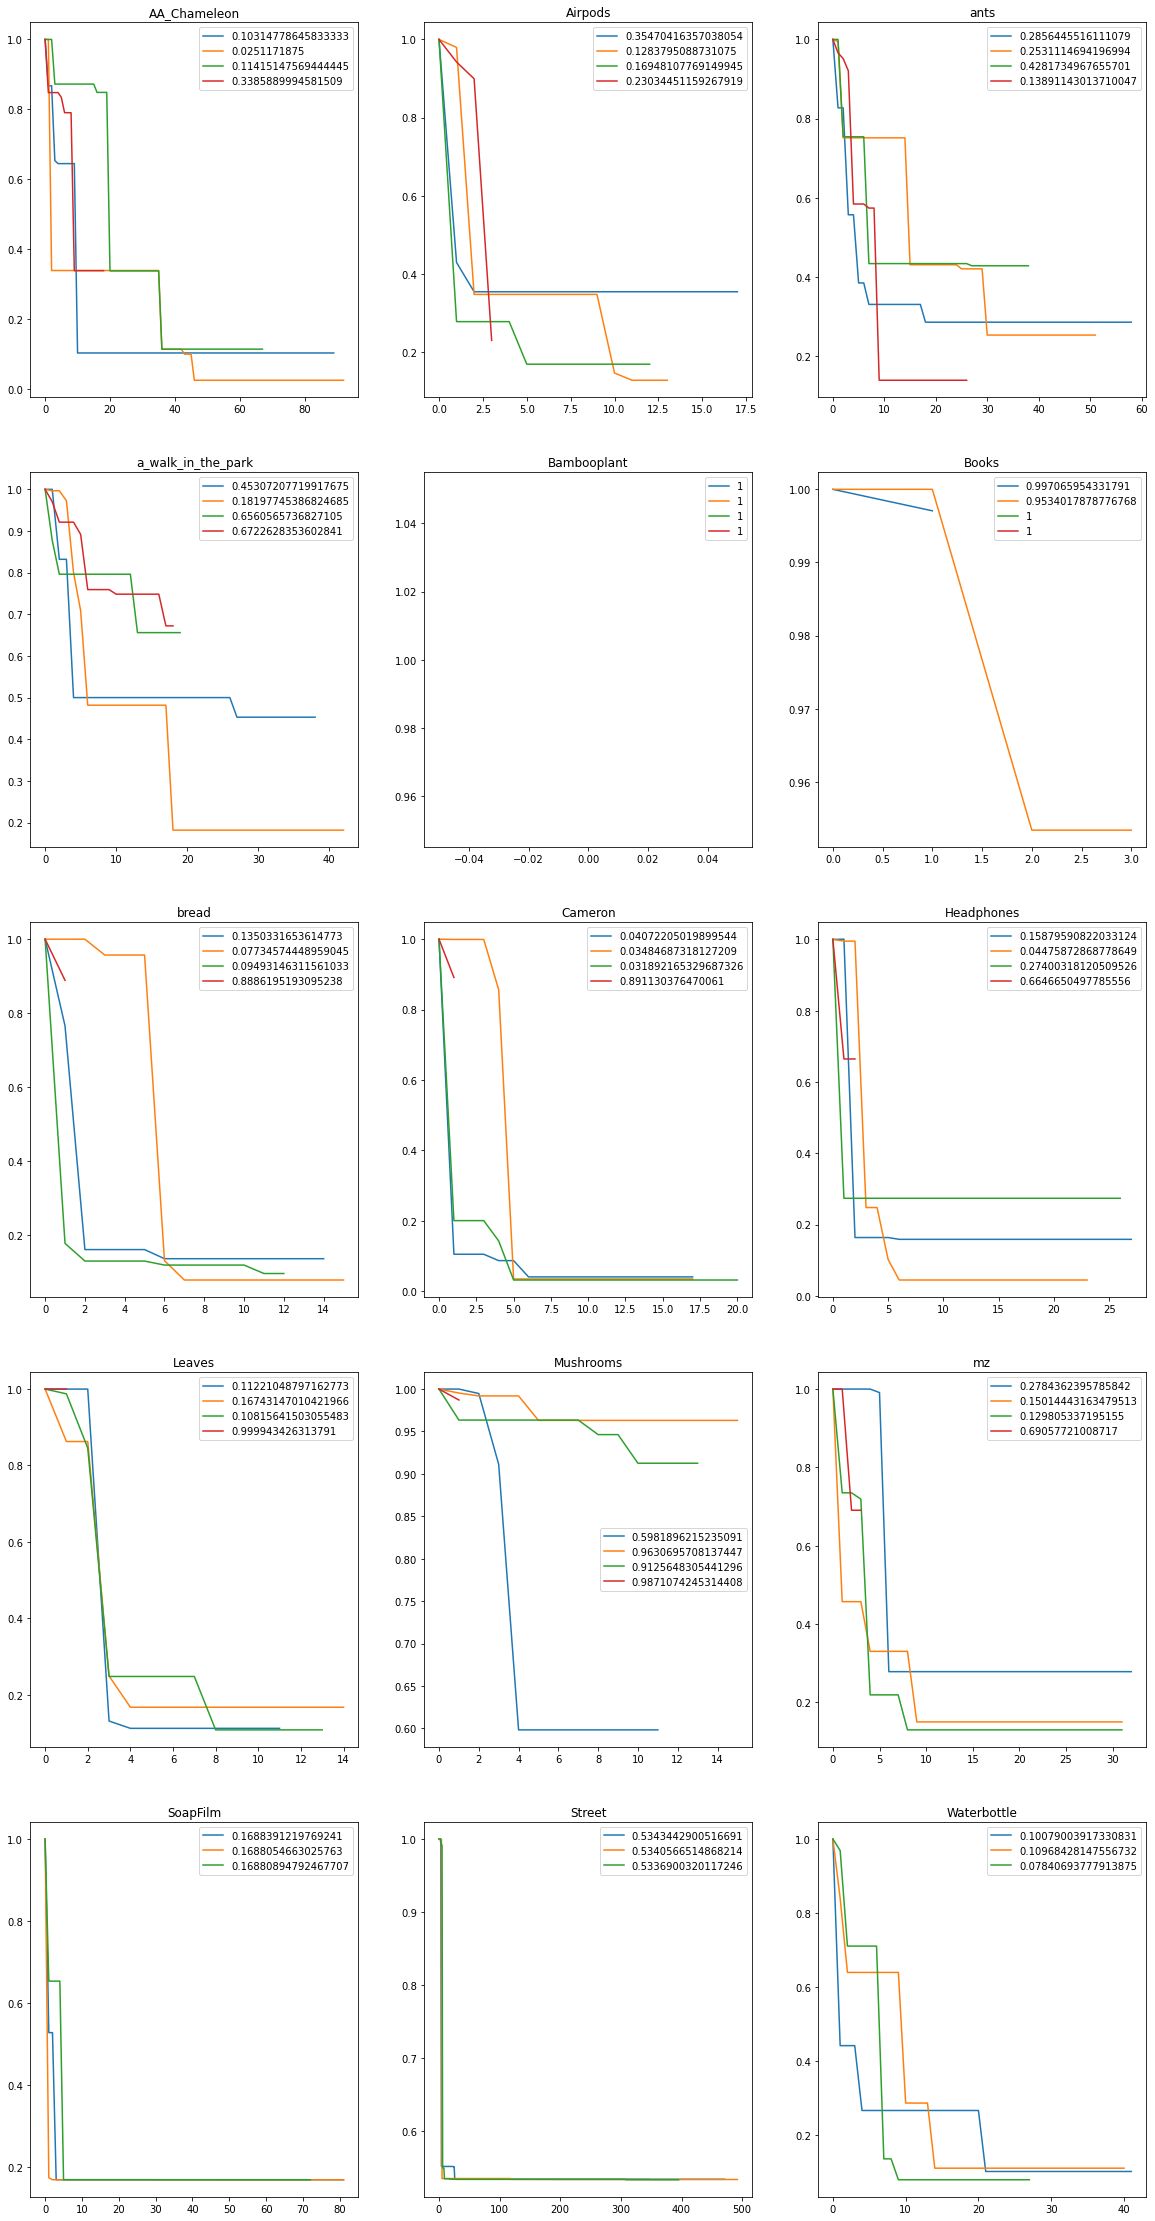

In [10]:
import math

cols = 3
total = len(rundata)
rows = math.ceil(total/cols)

index = 1;

plt.figure(figsize=[20,40])
for key in rundata:
    row = index % 3
    col = math.floor(index / 3)
    plt.subplot(rows,cols,index)
    plot_rundata(rundata[key], key=key)
    index +=1